In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib


In [4]:
# Load the dataset
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)
# df = pd.read_csv('Telco-Customer-Churn.csv')

# Drop customerID
df.drop('customerID', axis=1, inplace=True)

# Convert 'TotalCharges' to numeric (some may be spaces)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows with missing TotalCharges
df.dropna(inplace=True)

# Target variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})


In [5]:
# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing for numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Full preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [6]:
# Logistic Regression Pipeline
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Random Forest Pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])


In [7]:
# Logistic Regression params
logreg_params = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs']
}

# Random Forest params
rf_params = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_split': [2, 5]
}

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Grid Search for Logistic Regression
grid_logreg = GridSearchCV(logreg_pipeline, logreg_params, cv=5, scoring='accuracy')
grid_logreg.fit(X_train, y_train)

# Grid Search for Random Forest
grid_rf = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['SeniorCitizen',
                                                                          'tenure',
                                                                          'MonthlyCharges',
                                                                          'TotalCharges']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['gender',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'Contract',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod'])])),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__max_depth': [5, 10, None],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='accuracy')

In [8]:
# Evaluate Logistic Regression
print("Best Logistic Regression Model:")
print(grid_logreg.best_estimator_)
y_pred_log = grid_logreg.predict(X_test)
print(classification_report(y_test, y_pred_log))

# Evaluate Random Forest
print("Best Random Forest Model:")
print(grid_rf.best_estimator_)
y_pred_rf = grid_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

Best Logistic Regression Model:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                

In [9]:
# Save the best model
best_model = grid_rf if grid_rf.best_score_ > grid_logreg.best_score_ else grid_logreg
joblib.dump(best_model.best_estimator_, 'best_churn_model_pipeline.joblib')


['best_churn_model_pipeline.joblib']

In [10]:
# Load the model
loaded_model = joblib.load('best_churn_model_pipeline.joblib')

# Make predictions
predictions = loaded_model.predict(X_test)

In [11]:
print(predictions)

[0 0 1 ... 0 0 0]


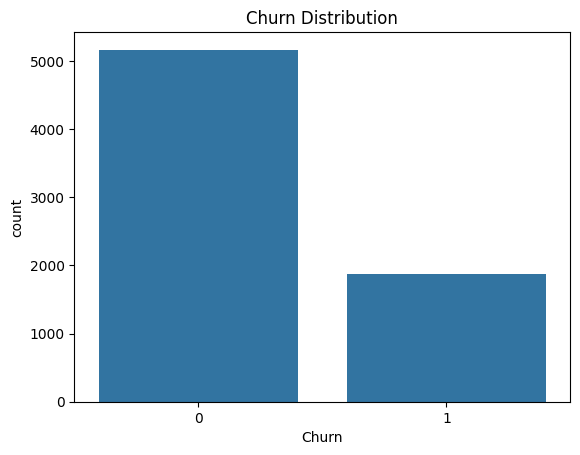

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Churn distribution
sns.countplot(data=df, x='Churn')
plt.title("Churn Distribution")
plt.show()

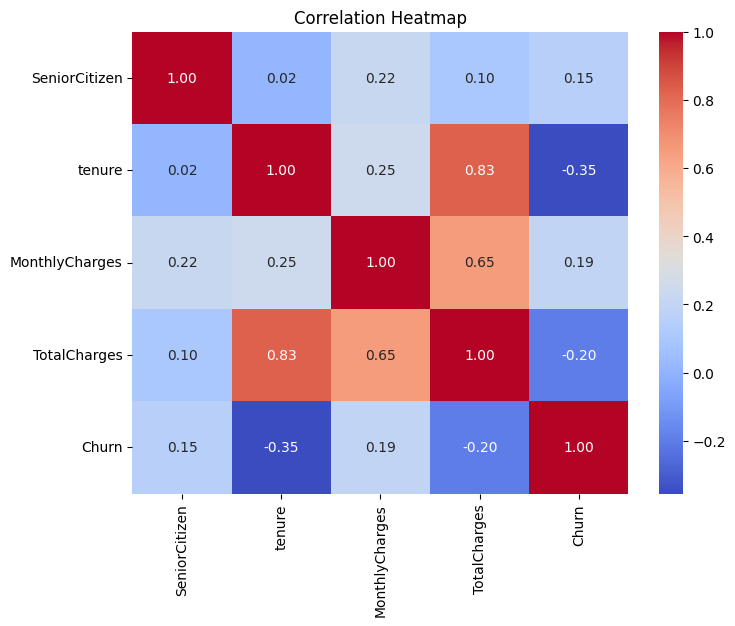

In [13]:
# Only numerical columns
corr = df[numerical_cols + ['Churn']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()


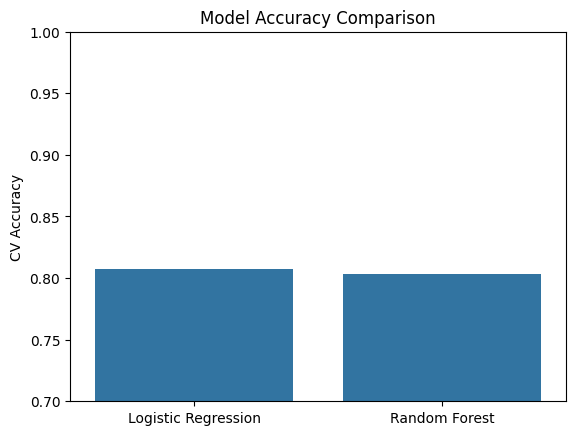

In [14]:
# Compare model accuracies from grid search
model_scores = {
    'Logistic Regression': grid_logreg.best_score_,
    'Random Forest': grid_rf.best_score_
}

sns.barplot(x=list(model_scores.keys()), y=list(model_scores.values()))
plt.ylabel('CV Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0.7, 1)
plt.show()
